KeyboardInterrupt: 

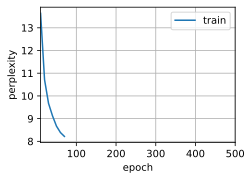

In [2]:
## 本文件实现了基础版本的循环神经网络，参考代码来源于李沐老师
## 数据集也参考来自李沐老师的代码

import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class RNNModelScratch:
    def __init__(self, batch_size, vocab_size, num_hiddens, device_name):
        self.vocab_size = vocab_size 
        self.num_hiddens = num_hiddens
        self.device = device_name
        self.params  = self.params(vocab_size, num_hiddens, self.device)
        self.state = (torch.zeros((batch_size, num_hiddens), device=device_name),)

    def __call__(self, inputs):
         inputs = F.one_hot(inputs.T, self.vocab_size).type(torch.float32)
         inputs = inputs.to(self.device)
         W_xh, W_hh, b_h, W_hq, b_q = self.params
         H, = self.state
         outputs = []
         for X in inputs:
            H = torch.tanh(torch.mm(X,W_xh) + torch.mm(H, W_hh) + b_h)
            Y = torch.mm(H,W_hq) + b_q
            outputs.append(Y)
         return torch.cat(outputs, dim=0), (H,)


    def normal(self, shape):
        return torch.randn(size=shape, device=self.device) * 0.01 

    def params(self, vocab_size, num_hiddens, device):
        num_inputs = num_outputs = vocab_size

        W_xh = self.normal((num_inputs, num_hiddens))
        W_hh = self.normal((num_hiddens,num_hiddens))
        b_h = torch.zeros(num_hiddens,device=self.device)

        W_hq = self.normal((num_hiddens, num_outputs))
        b_q = torch.zeros(num_outputs, device=self.device)

        params = [W_xh, W_hh, b_h, W_hq, b_q]

        for param in params:
            param.requires_grad_(True)
        
        return params 

def grad_clipping(net, theta):  
    """裁剪梯度。"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm


def train_one_step(net, train_iter, loss, updater, lr, device):
    timer = d2l.Timer()
    metric = d2l.Accumulator(2)
    for X, Y in train_iter:
        for s in net.state:
            s.detach_()
        y = Y.T.reshape(-1).to(device)
        l = loss(net(X)[0], y).mean()
        l.backward() 
        grad_clipping(net, 1)
        updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0]/ metric[1]), metric[1] / timer.stop()


def train_rnn(net, train_iter, loss, updater, lr, device, epoch):
    # loss = nn.CrossEntropyLoss()
    # updater = torch.optim.SGD(net.parameters(), lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, epoch])
    for epoch in range(epoch):
        # print(epoch)
        ppl, speed = train_one_step(net, train_iter, loss, updater, lr, device)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, [ppl])

    print(f'困惑度 {ppl:.1f}, {speed:.1f} 标记/秒 {str(device)}')


batch_size = 32
num_steps =  35
num_hiddens = 512
lr = 1 
epoch = 500

train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

test_rnn = RNNModelScratch(batch_size, len(vocab), num_hiddens, d2l.try_gpu())
loss = nn.CrossEntropyLoss()
updater = lambda batch_size: d2l.sgd(test_rnn.params, lr, batch_size)

train_rnn(test_rnn, train_iter, loss, updater, lr, d2l.try_gpu(), epoch)




In [ ]:
print("2")